# RCNN

**Reference:** https://www.youtube.com/watch?v=IcLEJB2pY2Y&t=2055s

In [1]:
%config Completer.use_jedi = False    # for autocompletion

In [6]:
import albumentations
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from PIL import Image
from PIL import ImageFile
from pprint import pprint
from tqdm import tqdm

In [60]:
# constants: configurations
if os.path.exists('gen-plate-dataset'):
    DATA_DIR = 'gen-plate-dataset'
else:
    DATA_DIR = os.path.join('..', 'datasets', 'unspaced-plate-dataset')
BATCH_SIZE = 1
IMAGE_WIDTH = 230
IMAGE_HEIGHT = 50
NUM_WORKERS = 12
DEVICE = 'cpu'  # cpu / cuda
LR = 1e-4

In [61]:
if os.sys.platform=='linux' and os.path.exists('../input/unspacednumberplate/unspaced-plate-dataset'):
    DATA_DIR = '../input/unspacednumberplate/unspaced-plate-dataset'

In [62]:
DATA_DIR

'../datasets/unspaced-plate-dataset'

# Save Data

In [32]:
MODEL_DIR = os.path.join('..','models')

try:
    os.mkdir(TRAIN_DIR)
except FileExistsError:
    pass

NameError: name 'TRAIN_DIR' is not defined

In [33]:
TRAINER_DIR = os.path.join(MODEL_DIR,'harshad')    # change this

try:
    os.mkdir(TRAINER_DIR)
except FileExistsError:
    pass

In [34]:
# change this for every training
# or it will overwrite your previous data

VER_FILE = os.path.join('text_recognition-ver-28.0.pth')

comment = '1) captcha architecture 2) unspaced 957'

In [35]:
# save state
def save_model():
    torch.save(
        {'lr': LR,
        'train_epoch': epoch_count,
        'model': PlateRecognizer(num_chars=len(lbl_enc.classes_)),
        'model_state_dict': model.state_dict(),
        'classes': lbl_enc.classes_,
        'optimizer_name': optimizer_name,
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': schedular.state_dict(),
        'scheduler_name': schedular_name,
        'loss': loss,
        'accuracy': accuracy,
        'comment':comment},
        VER_FILE
    )

# Dataset

In [63]:
# dataset creations

ImageFile.LOAD_TRUNCATED_IMAGES = True


class ClassificationDataset:
    def __init__(self, img_paths, targets, resize=None):
        self.img_paths = img_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [albumentations.Normalize(always_apply=True)])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, item_index):
        img = Image.open(self.img_paths[item_index])
        targets = self.targets[item_index]

        if self.resize is not None:
            img = img.resize((self.resize[1], self.resize[0]),
                             resample=Image.BILINEAR)

        img = np.array(img)
        augmented = self.aug(image = img)
        img = augmented['image']
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        return {
            'imgs': torch.tensor(img, dtype=torch.float),
            'targets': torch.tensor(targets, dtype=torch.long)
        }

# Engine

In [64]:
# engine


def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_fn(model, data_loader, optimizer):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad():
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            batch_preds, loss = model(**data)

            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Model

In [65]:
# model

class PlateRecognizer(nn.Module):
    def __init__(self, num_chars):
        super(PlateRecognizer, self).__init__()
        self.conv1 = nn.Conv2d(3,128, kernel_size=(3, 6), padding=(1, 1))
        self.max_pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1))
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.linear = nn.Linear(768, 64)
        self.drop = nn.Dropout(0.2)  # doesn't change size

        self.gru = nn.GRU(64,
                          32,
                          bidirectional = True,
                          num_layers=2,
                          dropout=0.25,
                          batch_first=True
                         )
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, imgs, targets=None):
        bs, c, w, h = imgs.size()
        # print(bs, c, w, h)    # for debugging
        x = F.relu(self.conv1(imgs))
        # print('Conv1', x.size())
        x = self.max_pool_1(x)
        # print('MaxPool', x.size())
        x = F.relu(self.conv2(x))
        # print('Conv2', x.size())
        x = self.max_pool_2(x)  # 1, 64, 12, 57
        # print('MaxPool', x.size())

        # to brind width first but in our case it's properly arranged
        x = x.permute(0, 3, 1, 2)  # 1, 57, 64, 12
        # print('Permute', x.size())
        x = x.view(bs, x.size(1), -1)
        # print('View', x.size())

        x = self.linear(x)
        x = self.drop(x)
        # print('Linear', x.size())

        x, _ = self.gru(x)
        # print('Recurrent', x.size())

        x = self.output(x)
        # print('output', x.size())

        x = x.permute(1, 0, 2)
        if targets is not None:
            # CTC
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(size=(bs, ),
                                       fill_value=log_probs.size(0),
                                       dtype=torch.int32)
            # print('input lengths', input_lengths)
            target_lengths = torch.full(size=(bs, ),
                                        fill_value=targets.size(1),
                                        dtype=torch.int32)
            # print('target lengths', target_lengths)
            loss = nn.CTCLoss(blank=0)(log_probs, targets,
                                       input_lengths, target_lengths)
            return x, loss

        return x, None

In [66]:
# for debugging model

cm = PlateRecognizer(19)
img = torch.rand(5, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
targets = torch.randint(1, 6, (5, 5))
x, loss = cm(img, targets)

del (cm)

# Train

In [67]:
# generate img & target list


def get_img_label():
    '''Returns tuple of img filename list and target_label list.'''
    img_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    img_files.extend(glob.glob(os.path.join(DATA_DIR, '*.png')))
    if os.sys.platform == 'win32':
        separator = '\\'
    else:
        separator = '/'
    targets_orig = [x.split(separator)[-1][:-4] for x in img_files]
    return img_files, targets_orig

In [68]:
# target preprocessing


def get_target_list(target_orig):
    targets = [[c for c in x] for x in targets_orig]
    targets_flat = [c for clist in targets for c in clist]
    return targets, targets_flat

In [69]:
# target encoding


def encode_labels(targets, targets_flat):
    lbl_enc = preprocessing.LabelEncoder()
    lbl_enc.fit(targets_flat)
    targets_enc = [lbl_enc.transform(x) for x in targets]
    # 1 is added to shift characters as 0 index will be reserved for null Value
    # null is not whitespace character
    targets_enc = np.array(targets_enc) + 1
    return lbl_enc, targets_enc

In [123]:
# decodes labels


def decode_predictions(preds, encoder, collapse_repeated=True):
    ''' Decodes CTC String to normal string'''
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy(
    )  # change cpu to cuda if training on gpu
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = ''
        prev_char = None
        for k in preds[j]:
            k = k - 1
            # k = -1 mean a empty value 
            if k == -1:
                if not collapse_repeated:
                    temp += '`'
            elif k==prev_char:
                if not collapse_repeated:
                    temp += encoder.inverse_transform([k])[0]
            else:
                # print(encoder.inverse_transform([k]), k)
                temp += encoder.inverse_transform([k])[0]
            prev_char = k
        tp = "" + temp
        # print(preds[j], targets[j], tp)
        cap_preds.append(tp)
    return cap_preds

In [71]:
# checks if all characters of targets are in predictions


def char_accuracy(preds, targets):
    sum_accuracy = 0
    total_preds = 0
    for index in range(len(preds)):
        correct_char = 0
        for char in preds[index]:
            if char in targets[index]:
                correct_char += 1
        accuracy = correct_char / len(preds[index])
        sum_accuracy += accuracy
        total_preds += 1
    return sum_accuracy / total_preds

In [72]:
# checks if all predictions are same as labels


def label_accuracy(preds, targets):
    correct_labels = 0
    for index in range(len(preds)):
        if preds[index] == targets[index]:
            correct_labels += 1
    return correct_labels / len(preds)

In [73]:
# data preprocessing & encoding

img_files, targets_orig = get_img_label()

targets, targets_flat = get_target_list(targets_orig)
lbl_enc, targets_enc = encode_labels(targets, targets_flat)

<ipython-input-69-735a22edcc22>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  targets_enc = np.array(targets_enc) + 1


In [74]:
len(targets_enc), len(img_files)

(1153, 1153)

In [75]:
# data splitting

(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets,
 test_orig_targets) = model_selection.train_test_split(img_files,
                                                       targets_enc,
                                                       targets_orig,
                                                       test_size=0.1,
                                                       random_state=42)

In [76]:
# train dataset & loader

train_dataset = ClassificationDataset(
                    img_paths=train_imgs, 
                    targets=train_targets,
                    resize=(IMAGE_HEIGHT, IMAGE_WIDTH)
                )

train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size = BATCH_SIZE,
                    num_workers = NUM_WORKERS,
                    shuffle = True
                )

# for debugging

# npimg = train_dataset[0]['imgs'].numpy()
# plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [77]:
# test_dataset & loader

test_dataset = ClassificationDataset(
                    img_paths = img_files,
                    targets = targets_enc,
                    resize = (IMAGE_HEIGHT, IMAGE_WIDTH)
                )
test_loader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS,
                shuffle = False
            )

# Data Visualization

In [78]:
lbl_enc.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [79]:
len(train_dataset), len(test_dataset)

(1037, 1153)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 50, 230])


('Image shape: ',
 torch.Size([3, 50, 230]),
 array(['M', 'H', '0', '2', 'B', 'T', '0', '6', '9', '8'], dtype='<U1'))

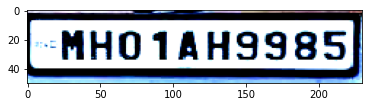

In [80]:
# train data visualization

img = train_dataset[11]['imgs']
lbl_int = train_dataset[0]['targets'] - 1    # 1 is subtracted as it was added during encoding process
label = lbl_enc.inverse_transform(lbl_int)
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
'Image shape: ', img.shape, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array(['M', 'H', '1', '2', 'F', 'Y', '2', '0', '3', '1'], dtype='<U1'),
 torch.Size([3, 50, 230]))

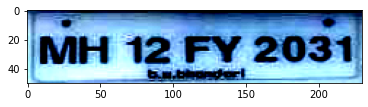

In [81]:
# test data visualiztion

img = test_dataset[0]['imgs']
lbl_int = test_dataset[0]['targets'] - 1 # 
label = lbl_enc.inverse_transform(lbl_int)
plt.imshow(img.permute(1, 2, 0))
label, img.shape

In [82]:
# model, optimizer & schedular

model = PlateRecognizer(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer_name = 'Adam'
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=4, verbose=True
)
schedular_name = 'ReduceLROnPlateau'



In [ ]:
# actual training

def run_training(model, train_loader, test_loader, optimizer, schedular, lbl_enc):
    global epoch_count
    global max_char_acc
    global max_label_acc
    for epoch in range(epoch_count, EPOCHS):
        train_loss = train_fn(model, train_loader, optimizer)
        valid_preds, valid_loss = eval_fn(model, test_loader, optimizer)
        
        valid_plate_preds = []
        for vp in valid_preds:
            current_preds = decode_predictions(vp, lbl_enc, False)
            valid_plate_preds.extend(current_preds)
            
        combined = list(zip(test_orig_targets, valid_plate_preds))
            
        char_acc = char_accuracy(test_orig_targets, valid_plate_preds)
        label_acc = label_accuracy(test_orig_targets, valid_plate_preds)
            
        # calculate accuracy of model and log it   
        pprint(combined[:10])
        print(f"Epoch:{epoch}, train_loss:{train_loss}, valid_loss={valid_loss}")
        print(f"char_accuracy:{char_acc}, label_accuracy:{label_acc}")
        
        loss['train'].append(train_loss)
        loss['valid'].append(valid_loss)
        accuracy['character'].append(char_acc)
        accuracy['label'].append(label_acc)
        
        epoch_count += 1
        schedular.step(valid_loss)
        
        if max_char_acc < char_acc or max_label_acc < label_acc:
            save_model()
            max_char_acc = char_acc
            max_label_acc = label_acc
            print('Model saved')
        


# Resume Training
Execute following cells only if you want to resume previously trained model.

In [233]:
# copy & paste files path of weights.pth & optimizer.pth

STATE_PATH = '../models/text_recognition-ver-32.0.pth'    # text-recognition-ver-X.X.pth

In [234]:
torch.device('cpu')
checkpoint = torch.load(STATE_PATH, map_location=torch.device(DEVICE))

In [235]:
checkpoint['accuracy']['character'][-1]    # last accuryacy

0.767142336472234

In [236]:
checkpoint['loss']['train'][-1], checkpoint['loss']['valid'][-1]    # last vloss

(0.689901365073266, 1.253345932389043)

In [237]:
# loads model and optimzer
LR = checkpoint['lr']
model = checkpoint['model']
epoch_count = checkpoint['train_epoch']
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')

PlateRecognizer(
  (conv1): Conv2d(3, 128, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=768, out_features=64, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (gru): GRU(64, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=37, bias=True)
)

In [238]:
if checkpoint['optimizer_name'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print('optimizer is loaded.')

optimizer is loaded.


In [239]:
if checkpoint['scheduler_name'] == 'ReduceLROnPlateau':
    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.8, patience=5, verbose=True
    )
    schedular.load_state_dict(checkpoint['scheduler_state_dict'])
    print('scheduler is loaded.')

scheduler is loaded.


In [240]:
loss = checkpoint['loss']
accuracy = checkpoint['accuracy']
'comment: '+ checkpoint['comment']

'comment: 1) captcha architecture 2) 2:1 real:generated dataset'

In [241]:
loss['valid'][-1], accuracy['character'][-1], len(loss['valid'])

(1.253345932389043, 0.767142336472234, 93)

In [115]:
print('LR: ', LR,'\nTrained_epoch_count: ', epoch_count, '\nEPOCHS: ', EPOCHS)

NameError: name 'EPOCHS' is not defined

Change **EPOCH** such that **EPOCH > epoch_count**

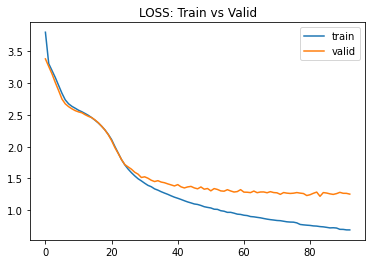

In [242]:
plt.title('LOSS: Train vs Valid')
plt.plot(loss['train'])
plt.plot(loss['valid'])
plt.legend(['train', 'valid'])
plt.show()

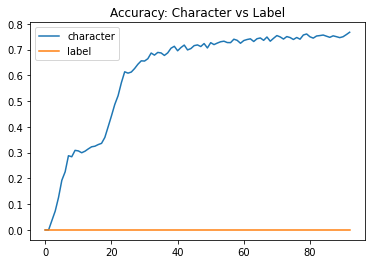

In [243]:
plt.title('Accuracy: Character vs Label')
plt.plot(accuracy['character'])
plt.plot(accuracy['label'])
plt.legend(['character', 'label'])
plt.show()

In [244]:
valid_preds, valid_loss = eval_fn(model, test_loader, optimizer)

valid_plate_preds = []
for vp in valid_preds:
    current_preds = decode_predictions(vp, lbl_enc)
    valid_plate_preds.extend(current_preds)

combined = list(zip(targets_orig, valid_plate_preds))

char_acc = char_accuracy(targets_orig, valid_plate_preds)
label_acc = label_accuracy(targets_orig, valid_plate_preds)

pprint(combined[:10])
print(f"valid_loss={valid_loss}")
print(f"char_accuracy:{char_acc}, label_accuracy:{label_acc}")

100%|██████████| 1153/1153 [00:28<00:00, 40.68it/s]


[('MH12FY2031', 'MH02BY2031'),
 ('MH12FK3242', 'MH12BT3242'),
 ('WB062182', 'WB062182'),
 ('MH14BX0026', 'MH14BP0026'),
 ('MH46N0950', 'MH4BN0950'),
 ('HR26BG0383', 'HR26BR0383'),
 ('GJ18BA5429', 'GJ13A5429'),
 ('MK20TC189B', 'MH2C189B'),
 ('WB06E0652', 'WB06B0652'),
 ('AP31BT9732', 'AP3BJ9732')]
valid_loss=0.6496338580265731
char_accuracy:0.865169975057222, label_accuracy:0.12055507372072853


# Start Training 

In [ ]:
# one-time initialization parameters
loss = {'train': [], 'valid': []}
accuracy = {'character': [], 'label': []}
epoch_count = 0
max_char_acc = 0
max_label_acc = 0

In [ ]:
EPOCHS = 100

In [ ]:
run_training(model, train_loader, test_loader, optimizer, schedular, lbl_enc);

In [ ]:
plt.title('LOSS: Train vs Valid')
plt.plot(loss['train'])
plt.plot(loss['valid'])
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
plt.title('Accuracy: Character vs Label')
plt.plot(accuracy['character'])
plt.plot(accuracy['label'])
plt.legend(['character', 'label'])
plt.show()

# jovian commit

In [ ]:
!pip install jovian

In [ ]:
import jovian

In [ ]:
jovian.commit(project="text-recognition")

In [ ]:
!ls